In [46]:
import os
import pandas as pd
from kernels.wrapper import MODELS, KernelModelWrapper
from dataset.ipc2023_learning_domain_info import IPC2023_LEARNING_DOMAINS, get_test_ipc2023_learning_instance_files, get_best_bound
from itertools import product
from IPython.display import display, HTML
from util.scrape_log import scrape_search_log
from util.visualise import *

In [47]:
_PAPER_DIR=str(Path.home())+"/papers/manuscripts/23-genplan-kernels"

In [48]:
pd.options.display.float_format = "{:.1f}".format

In [49]:
_LOG_DIR = "logs/test_ipc2023"
_DIFFICULTIES = ["easy", "medium", "hard"]
_ITERATIONS = [str(i) for i in [1]]
_MODELS = [
  # "linear-regression", 
  "ridge", 
  "lasso", 
  "linear-svr", 
  "quadratic-svr", 
  "cubic-svr",
  "rbf-svr", 
]
_REP="llg2"
CONFIGS = list(product(_MODELS, _ITERATIONS))

In [50]:
def get_data(domain):
  data = {
  }

  test_files = get_test_ipc2023_learning_instance_files()

  for config in ["muninn"] + CONFIGS:
    d = {
      "solved": [],
      "expanded": [],
      "cost": [],
      "first_h": [],
      "quality": [],
      "c_opt": [],
      "difficulty": [],
    }

    if config == "muninn":
      model = "muninn"
    else:
      model, iterations = config

    for difficulty in _DIFFICULTIES:
      for df, pf in test_files[domain]:
        if not difficulty in pf:
          continue
        pf_name = os.path.basename(pf).replace(".pddl", "")

        if model=="muninn":
          stats = {
            "first_h": -1,
            "solved": 0,
            "time": -1,
            "cost": -1,
            "expanded": -1,
            "evaluated": -1,
          }

          log_file = f"logs/logs_muninn/{domain}_{difficulty}_{pf_name}_domain-knowledge-{domain}.dk.log"
        
          if not os.path.exists(log_file):
            continue

          """
          [1] Subplan: 10, Heuristic: 9.998 -> goal, Expanded: 22, Generated: 86 (260 ms)
          Writing file "plan.1" (10 actions)
          Planned for 0 minutes and 0 seconds
          """

          for line in open(log_file, 'r').readlines():
            if "[1]" in line and stats['solved'] == 0:
              toks = line.replace(",", "").replace("(", "").split()
              stats["first_h"] = float(toks[4])
            if "Writing file" in line:
              toks = line.replace(",", "").replace("(", "").split()
              stats["cost"] = int(toks[-2])
              stats["solved"] = 1
        else:
          log_file = f"{_LOG_DIR}/{domain}_{difficulty}_{pf_name}_-scratch-sv11-dc6693-trained_models_kernel-{model}_{_REP}_ipc2023-learning-{domain}_wl_{iterations}_0.joblib.log"
        
          if not os.path.exists(log_file):
            continue

          stats = scrape_search_log(log_file)


        for k in d:
          if k in stats:
            d[k].append(stats[k])
        
        c = stats["cost"]
        c_opt = get_best_bound(domain, difficulty, pf_name)
        quality = c_opt / c
        quality = max(quality, 0)
        quality = min(quality, 1)
        d["quality"].append(quality)
        d["c_opt"].append(c_opt)
        d["difficulty"].append(difficulty)
        
    data[config] = d

  return data

In [51]:
def get_metrics_df(data):
  d = {
    "config": [],
    "quality": [],
    "solved": [],
    "tried": [],
    "e_quality": [],
    "e_solved": [],
    "e_tried": [],
    "m_quality": [],
    "m_solved": [],
    "m_tried": [],
    "h_quality": [],
    "h_solved": [],
    "h_tried": [],
  }
  for config in ["muninn"] +CONFIGS:
    d["config"].append("muninn" if config=="muninn" else "_".join(config))
    d["quality"].append(sum(data[config]["quality"]))
    d["solved"].append(sum(data[config]["solved"]))
    d["tried"].append(len(data[config]["solved"]))
    for difficulty in _DIFFICULTIES:
      quality = 0
      solved = 0
      tried = 0
      if config=="muninn":
        print(difficulty, len(data[config]["solved"]))
      for i, prob_solved in enumerate(data[config]["solved"]):
        if data[config]["difficulty"][i] == difficulty:
          quality += data[config]["quality"][i]
          solved += prob_solved
          tried += 1
      d[f"{difficulty[0]}_quality"].append(quality)
      d[f"{difficulty[0]}_solved"].append(solved)
      d[f"{difficulty[0]}_tried"].append(tried)
  return pd.DataFrame(d)

In [52]:
def get_table_df():
  d = {
    "domain": [],
    "muninn": [],
  }
  for config in CONFIGS:
    d['_'.join(config)] = []

  sum_scores = {config: 0 for config in ["muninn"] + CONFIGS}

  for domain in IPC2023_LEARNING_DOMAINS:
    data = get_data(domain)
    d["domain"].append(domain)

    score = sum(data["muninn"]["quality"])
    d["muninn"].append(score)
    sum_scores["muninn"] += score
    
    for config in CONFIGS:
      score = sum(data[config]["quality"])
      d['_'.join(config)].append(score)
      sum_scores[config] += score
  

  d["domain"].append("sum")
  d["muninn"].append(sum_scores["muninn"])
  for config in CONFIGS:
    d['_'.join(config)].append(sum_scores[config])

  return pd.DataFrame(d)

In [53]:
scores_df = get_table_df()
scores = scores_df.to_numpy()
scores = scores[:,1:]
display(scores_df)

,domain,muninn,ridge_1,lasso_1,linear-svr_1,quadratic-svr_1,cubic-svr_1,rbf-svr_1
0,blocksworld,39.0,4.9,11.5,18.9,14.1,10.4,15.7
1,childsnack,11.0,20.7,8.8,17.1,10.0,10.0,13.0
2,ferry,46.0,36.3,60.6,75.6,71.5,57.1,34.6
3,floortile,0.0,0.9,2.9,1.9,0.0,0.0,0.0
4,miconic,30.0,28.3,30.0,28.7,28.5,28.9,28.5
5,rovers,14.2,9.7,16.0,16.3,17.1,17.5,14.2
6,satellite,18.0,11.3,7.5,5.3,14.0,13.4,8.4
7,sokoban,25.2,34.8,23.0,35.0,30.5,28.0,27.9
8,spanner,32.0,24.9,30.0,25.9,25.9,26.3,25.9
9,transport,17.0,12.2,32.2,17.4,30.2,28.1,28.6


In [54]:
ret  = r"\begin{tabular}{c c c c c c c c} \toprule Domain & \header{Muninn} "
for iterations in _ITERATIONS:
  for model in _MODELS:
    ret += f"& \\header{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'

for domain, scores_domain in zip(IPC2023_LEARNING_DOMAINS, scores):
  ret += domain
  best_score = max(scores_domain)
  for score in scores_domain:
    if score==best_score:
      ret += f" & \\textbf{{{score:.1f}}}"
    else:
      ret += f" & {score:.1f}"
  ret += "\\\\ \n"

ret += "\midrule  sum"
best_score = max(scores[-1])
for score in scores[-1]:
    if score==best_score:
      ret += f" & \\textbf{{{score:.1f}}}"
    else:
      ret += f" & {score:.1f}"
ret += "\\\\"

ret += r"\bottomrule\end{tabular}"

f = open(f"{_PAPER_DIR}/figures/scores.tex", 'w')
f.write(ret)
f.close()

In [55]:
for domain in IPC2023_LEARNING_DOMAINS:
  print(domain)
  data = get_data(domain)
  display(get_metrics_df(data))

blocksworld
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,39.0,39,90,30.0,30,30,9.0,9,30,0,0,30
1,ridge_1,4.9,8,60,4.9,8,30,0.0,0,30,0,0,0
2,lasso_1,11.5,21,60,11.5,21,30,0.0,0,30,0,0,0
3,linear-svr_1,18.9,29,60,18.3,28,30,0.7,1,30,0,0,0
4,quadratic-svr_1,14.1,23,60,14.1,23,30,0.0,0,30,0,0,0
5,cubic-svr_1,10.4,18,60,10.4,18,30,0.0,0,30,0,0,0
6,rbf-svr_1,15.7,24,60,15.7,24,30,0.0,0,30,0,0,0


childsnack
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,11.0,11,90,11.0,11,30,0,0,30,0,0,30
1,ridge_1,20.7,28,60,20.7,28,30,0,0,30,0,0,0
2,lasso_1,8.8,9,60,8.8,9,30,0,0,30,0,0,0
3,linear-svr_1,17.1,18,60,17.1,18,30,0,0,30,0,0,0
4,quadratic-svr_1,10.0,10,60,10.0,10,30,0,0,30,0,0,0
5,cubic-svr_1,10.0,10,60,10.0,10,30,0,0,30,0,0,0
6,rbf-svr_1,13.0,13,60,13.0,13,30,0,0,30,0,0,0


ferry
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,46.0,46,90,30.0,30,30,16.0,16,30,0,0,30
1,ridge_1,36.3,41,90,26.9,30,30,9.3,11,30,0,0,30
2,lasso_1,60.6,61,90,29.6,30,30,30.0,30,30,1,1,30
3,linear-svr_1,75.6,76,90,29.6,30,30,30.0,30,30,16,16,30
4,quadratic-svr_1,71.5,72,90,29.5,30,30,30.0,30,30,12,12,30
5,cubic-svr_1,57.1,58,90,29.1,30,30,26.9,27,30,1,1,30
6,rbf-svr_1,34.6,35,90,29.6,30,30,5.0,5,30,0,0,30


floortile
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,0.0,0,90,0.0,0,30,0,0,30,0,0,30
1,ridge_1,0.9,1,30,0.9,1,30,0,0,0,0,0,0
2,lasso_1,2.9,3,30,2.9,3,30,0,0,0,0,0,0
3,linear-svr_1,1.9,2,30,1.9,2,30,0,0,0,0,0,0
4,quadratic-svr_1,0.0,0,30,0.0,0,30,0,0,0,0,0,0
5,cubic-svr_1,0.0,0,30,0.0,0,30,0,0,0,0,0,0
6,rbf-svr_1,0.0,0,30,0.0,0,30,0,0,0,0,0,0


miconic
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,30.0,30,90,30.0,30,30,0,0,30,0,0,30
1,ridge_1,28.3,30,60,28.3,30,30,0,0,30,0,0,0
2,lasso_1,30.0,30,60,30.0,30,30,0,0,30,0,0,0
3,linear-svr_1,28.7,30,60,28.7,30,30,0,0,30,0,0,0
4,quadratic-svr_1,28.5,30,60,28.5,30,30,0,0,30,0,0,0
5,cubic-svr_1,28.9,30,60,28.9,30,30,0,0,30,0,0,0
6,rbf-svr_1,28.5,30,60,28.5,30,30,0,0,30,0,0,0


rovers
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,14.2,15,90,14.2,15,30,0,0,30,0,0,30
1,ridge_1,9.7,13,60,9.7,13,30,0,0,30,0,0,0
2,lasso_1,16.0,19,60,16.0,19,30,0,0,30,0,0,0
3,linear-svr_1,16.3,22,60,16.3,22,30,0,0,30,0,0,0
4,quadratic-svr_1,17.1,21,60,17.1,21,30,0,0,30,0,0,0
5,cubic-svr_1,17.5,22,60,17.5,22,30,0,0,30,0,0,0
6,rbf-svr_1,14.2,18,60,14.2,18,30,0,0,30,0,0,0


satellite
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,18.0,18,90,16.0,16,30,2,2,30,0,0,30
1,ridge_1,11.3,23,60,11.3,23,30,0,0,30,0,0,0
2,lasso_1,7.5,12,60,7.5,12,30,0,0,30,0,0,0
3,linear-svr_1,5.3,15,60,5.3,15,30,0,0,30,0,0,0
4,quadratic-svr_1,14.0,24,60,14.0,24,30,0,0,30,0,0,0
5,cubic-svr_1,13.4,24,60,13.4,24,30,0,0,30,0,0,0
6,rbf-svr_1,8.4,16,60,8.4,16,30,0,0,30,0,0,0


sokoban
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,25.2,27,90,25.2,27,30,0.0,0,30,0,0,30
1,ridge_1,34.8,38,90,26.9,30,30,8.0,8,30,0,0,30
2,lasso_1,23.0,23,90,23.0,23,30,0.0,0,30,0,0,30
3,linear-svr_1,35.0,38,90,27.0,30,30,8.0,8,30,0,0,30
4,quadratic-svr_1,30.5,33,90,26.7,29,30,3.7,4,30,0,0,30
5,cubic-svr_1,28.0,31,90,27.0,30,30,1.0,1,30,0,0,30
6,rbf-svr_1,27.9,30,90,27.9,30,30,0.0,0,30,0,0,30


spanner
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,32.0,32,90,30.0,30,30,2,2,30,0,0,30
1,ridge_1,24.9,29,60,24.9,29,30,0,0,30,0,0,0
2,lasso_1,30.0,30,60,30.0,30,30,0,0,30,0,0,0
3,linear-svr_1,25.9,30,60,25.9,30,30,0,0,30,0,0,0
4,quadratic-svr_1,25.9,30,60,25.9,30,30,0,0,30,0,0,0
5,cubic-svr_1,26.3,30,60,26.3,30,30,0,0,30,0,0,0
6,rbf-svr_1,25.9,30,60,25.9,30,30,0,0,30,0,0,0


transport
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,17.0,17,90,17.0,17,30,0.0,0,30,0,0,30
1,ridge_1,12.2,21,60,10.5,18,30,1.6,3,30,0,0,0
2,lasso_1,32.2,33,60,29.2,30,30,3.0,3,30,0,0,0
3,linear-svr_1,17.4,26,60,15.7,23,30,1.7,3,30,0,0,0
4,quadratic-svr_1,30.2,32,60,28.4,30,30,1.8,2,30,0,0,0
5,cubic-svr_1,28.1,30,60,28.1,30,30,0.0,0,30,0,0,0
6,rbf-svr_1,28.6,31,60,27.6,30,30,1.0,1,30,0,0,0


In [56]:
ret  = r"\begin{tabular}{c c c c c c c c c} \toprule Domain & Difficulty & \header{Muninn} "
for iterations in _ITERATIONS:
  for model in _MODELS:
    ret += f"& \\header{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'

all_solved = {
  "easy": np.zeros(7).astype(int),
  "medium": np.zeros(7).astype(int),
  "hard": np.zeros(7).astype(int),
  "all": np.zeros(7).astype(int),
}

for domain, scores_domain in zip(IPC2023_LEARNING_DOMAINS, scores):
  ret += f"\\multirow{{4}}{{*}}{{{domain}}}"
  data = (get_metrics_df(get_data(domain)).to_numpy())
  solved = {
    "easy": data[:,5].T,
    "medium": data[:,8].T,
    "hard": data[:,11].T,
    "all": data[:,2].T,
  }
  for difficulty in solved:
    ret += f" & {difficulty}"
    scores_domain = solved[difficulty]
    all_solved[difficulty] += scores_domain.astype(int)
    best_score = max(scores_domain)
    for score in scores_domain:
      if score == 0:
        ret += f" & -"
      elif score==best_score:
        ret += f" & \\textbf{{{score}}}"
      else:
        ret += f" & {score}"
    ret += "\\\\ \n"
    if difficulty=="hard":
      ret += " \cmidrule(lr){2-9}"
  ret += " \midrule "

ret += f"\\multirow{{4}}{{*}}{{sum}}"
for difficulty in all_solved:
  scores = all_solved[difficulty]
  best_score = max(scores)
  ret += f" & {difficulty}"
  for score in scores:
      if score == 0:
        ret += f" & -"
      elif score==best_score:
        ret += f" & \\textbf{{{score}}}"
      else:
        ret += f" & {score}"
  ret += "\\\\"
  if difficulty=="hard":
    ret += " \cmidrule(lr){2-9}"

ret += r"\bottomrule\end{tabular}"

f = open(f"{_PAPER_DIR}/figures/coverage.tex", 'w')
f.write(ret)
f.close()

easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90


In [60]:
os.makedirs("plots", exist_ok=True)
for domain in IPC2023_LEARNING_DOMAINS:
  try:
    data = get_data(domain)

    max_val = 0

    for config in CONFIGS:
      cs = np.array(data[config]["cost"])
      c_opts = np.array(data[config]["c_opt"])
      index = np.where(cs != -1)
      cs = cs[index]
      c_opts = c_opts[index]
      plt.scatter(c_opts, cs, label="_".join(config))
      max_val = max([max_val, max(cs), max(c_opts)])
    
    plt.title(domain)
    plt.plot([1, max_val], [1, max_val], alpha=0.5, linestyle="dotted", c='k')
    plt.ylabel("C")
    plt.xlabel("C* (not necessarily optimal)")
    plt.legend()
    # plt.show()
    plt.savefig(f"plots/{_REP}_cost_ipc2023-learning-{domain}.png")
  except:
    pass
  plt.clf()
print("c vs c* saved")

c vs c* saved


<Figure size 640x480 with 0 Axes>

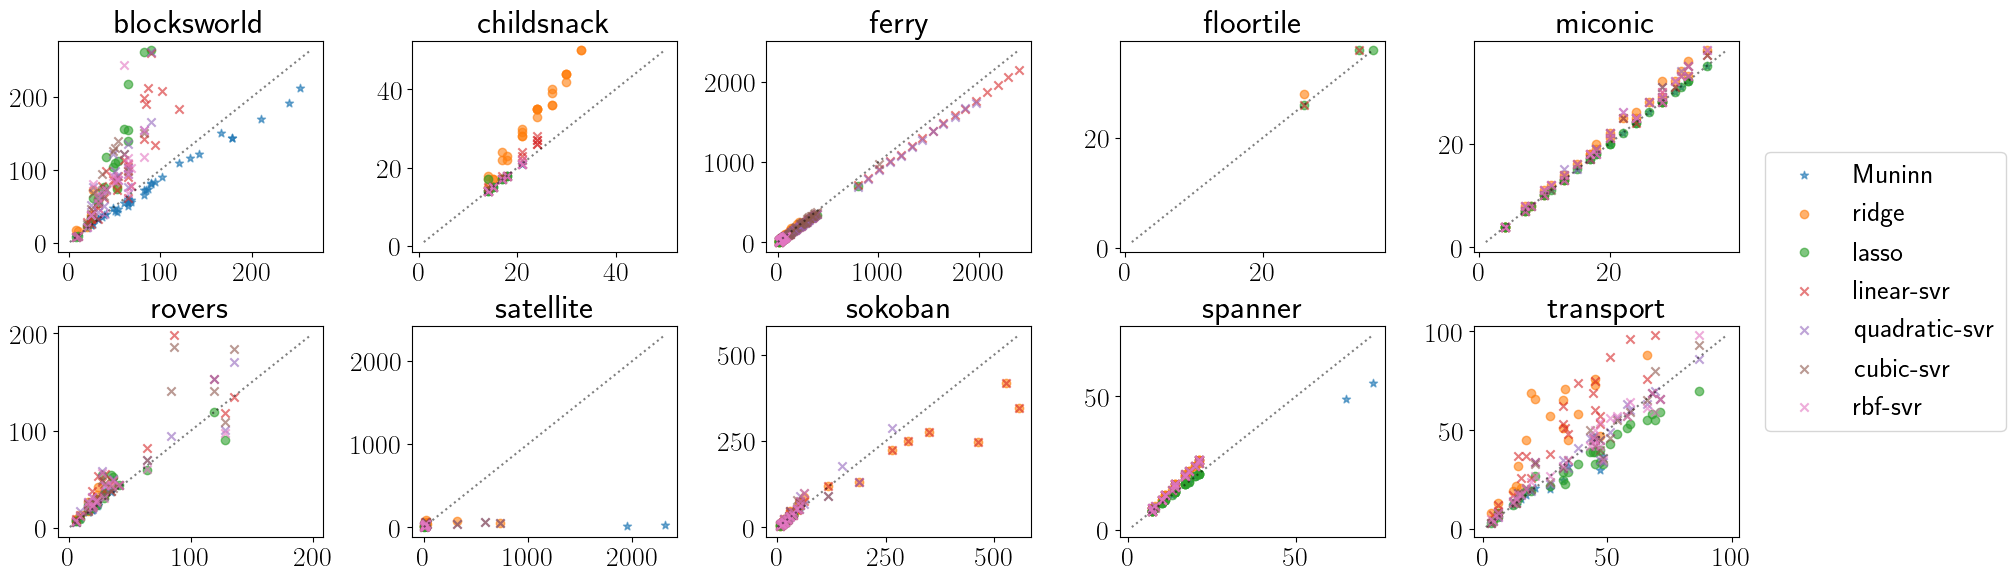

In [119]:
plt.rcParams.update({
  "text.usetex": True,
  "font.size": 20,
})

fig, axs = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False, figsize=(18, 6))
fig.tight_layout()

for k, domain in enumerate(IPC2023_LEARNING_DOMAINS):
  i = k // 5
  j = k % 5
  data = get_data(domain)
  max_val = 0

  for config in ["muninn"] + CONFIGS:
    cs = np.array(data[config]["cost"])
    c_opts = np.array(data[config]["c_opt"])
    index = np.where(cs != -1)
    cs = cs[index]
    c_opts = c_opts[index]
    label = "Muninn" if config == "muninn" else config[0]
    if config=="muninn":
      marker='*'
    elif "svr" in config[0]:
      marker='x'
    else:
      marker='o'
    axs[i,j].scatter(c_opts, cs, label=label, alpha=0.6, marker=marker)
    try:
      max_val = max([max_val, max(cs), max(c_opts)])
    except:
      pass
  
  axs[i,j].plot([1, max_val], [1, max_val], alpha=0.5, linestyle="dotted", c='k')
  axs[i,j].set_title(domain)

plt.legend(loc=(1.1, 0.5))
plt.savefig(f"{_PAPER_DIR}/figures/cost.pdf", bbox_inches="tight")
plt.show()

In [58]:
os.makedirs("plots", exist_ok=True)
for domain in IPC2023_LEARNING_DOMAINS:
  try:
    data = get_data(domain)

    max_val = 0

    my_dict = {}

    fig, ax = plt.subplots()

    for config in CONFIGS:
      expanded = np.array(data[config]["expanded"])
      # index = np.where(expanded != -1)
      expanded = expanded[index]
      my_dict["_".join(config)] = expanded
    
    plt.yscale("log")
    plt.title(domain)
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    # plt.ylim(bottom=1)
    # plt.show()
    plt.savefig(f"plots/{_REP}_expanded_ipc2023-learning-{domain}.png")
  except:
    pass
  plt.clf()
print("expansions saved")

expansions saved


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>